# Deep Learning gyakorlat


## 9. gyakorlat: objektum észlelése
### 2024. november 21.

In [ ]:
!gdown --id 102Dp4DZHeLTIq_1jGh1m6dSOyGnkbxA3
!gdown --id 18yJf5Z5sBEMD9BlWjPXFJg5UkLt5riff

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=102Dp4DZHeLTIq_1jGh1m6dSOyGnkbxA3
To: /content/annotations.zip
100% 2.62k/2.62k [00:00<00:00, 7.58MB/s]
/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=18yJf5Z5sBEMD9BlWjPXFJg5UkLt5riff
To: /content/images.zip
100% 2.71M/2.71M [00:00<00:00, 123MB/s]


In [ ]:
!mkdir Caltech

!unzip annotations.zip -d Caltech/annotations
!unzip images.zip -d Caltech

Archive:  annotations.zip
  inflating: Caltech/annotations/chair.csv  
  inflating: Caltech/annotations/pizza.csv  
  inflating: Caltech/annotations/cup.csv  
Archive:  images.zip
  inflating: Caltech/images/cup/image_0048.jpg  
  inflating: Caltech/images/cup/image_0044.jpg  
  inflating: Caltech/images/cup/image_0055.jpg  
  inflating: Caltech/images/cup/image_0032.jpg  
  inflating: Caltech/images/cup/image_0053.jpg  
  inflating: Caltech/images/cup/image_0011.jpg  
  inflating: Caltech/images/cup/image_0037.jpg  
  inflating: Caltech/images/cup/image_0051.jpg  
  inflating: Caltech/images/cup/image_0012.jpg  
  inflating: Caltech/images/cup/image_0043.jpg  
  inflating: Caltech/images/cup/image_0047.jpg  
  inflating: Caltech/images/cup/image_0054.jpg  
  inflating: Caltech/images/cup/image_0005.jpg  
  inflating: Caltech/images/cup/image_0022.jpg  
  inflating: Caltech/images/cup/image_0040.jpg  
  inflating: Caltech/images/cup/image_0034.jpg  
  inflating: Caltech/images/cup/imag

In [ ]:
 import os
 os.environ['TF_USE_LEGACY_KERAS']='1'

In [ ]:
import os
# define the base path to the input dataset and then use it to derive
# the path to the input images and annotation CSV files
BASE_PATH = "Caltech"
IMAGES_PATH = os.path.sep.join([BASE_PATH, "images"])
ANNOTS_PATH = os.path.sep.join([BASE_PATH, "annotations"])

In [ ]:
# define the path to the base output directory
BASE_OUTPUT = "Caltech/output"
# define the path to the output model, label binarizer, plots output
# directory, and testing image paths
MODEL_PATH = os.path.sep.join([BASE_OUTPUT, "detector.h5"])
LB_PATH = os.path.sep.join([BASE_OUTPUT, "lb.pickle"])
PLOTS_PATH = os.path.sep.join([BASE_OUTPUT, ""])
TEST_PATHS = os.path.sep.join([BASE_OUTPUT, "test_paths.txt"])

In [ ]:
# initialize our initial learning rate, number of epochs to train
# for, and the batch size
INIT_LR = 1e-4
NUM_EPOCHS = 20
BATCH_SIZE = 32

VGG16: A CNN architektúra, amely alaphálózatként szolgál, amelyet módosítunk a többosztályos határoló doboz regresszióhoz, majd finomhangolunk az adathalmazunkon.
tf.keras: Importok a TensorFlow/Keras rendszerből, amelyek rétegtípusokból, optimalizálókból és képbetöltési/előfeldolgozási rutinokból állnak.
LabelBinarizer: scikit-learnben implementált one-hot kódolás.
train_test_split: A scikit-learn kényelmi segédprogramja az adathalmazunk tréning és tesztelési részhalmazokra való felosztásához.
paths: Az imutils könyvtáram a képfájlok elérési útvonalainak megragadására egy tetszőleges könyvtárból és egy listában való tárolására.
matplotlib: A Python ábrázoló csomagja
numpy: Python szabványos numerikus feldolgozó könyvtára
cv2: Az OpenCV könyvtár

In [ ]:
# import the necessary packages
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import pickle
import cv2
import os

Négy üres listát inicializálunk az adatainkhoz kapcsolódóan; ezek a listák hamarosan feltöltődnek, hogy tartalmazzák:

data: Képek
labels: osztálycímkék
bboxes: Célpont határoló doboz (x, y)-koordinátái
imagePaths: A lemezen található képeink fájlútvonala.

Most, hogy a listáinkat inicializáltuk, a következő három kódblokkban előkészítjük az adatainkat és feltöltjük ezeket a listákat, hogy azok bemenetként szolgálhassanak a többosztályos határoló doboz regressziós képzéshez:

In [ ]:
# initialize the list of data (images), class labels, target bounding
# box coordinates, and image paths
print("[INFO] loading dataset...")
data = []
labels = []
bboxes = []
imagePaths = []

[INFO] loading dataset...


In [ ]:
# loop over all CSV files in the annotations directory
for csvPath in paths.list_files(ANNOTS_PATH, validExts=(".csv")):
	# load the contents of the current CSV annotations file
	rows = open(csvPath).read().strip().split("\n")
	# loop over the rows
	for row in rows:
		# break the row into the filename, bounding box coordinates,
		# and class label
		row = row.split(",")
		(filename, width, height, label, startX, startY, endX, endY) = row
    # derive the path to the input image, load the image (in
		# OpenCV format), and grab its dimensions
		imagePath = os.path.sep.join([IMAGES_PATH,
			filename])
		image = cv2.imread(imagePath)
		(h, w) = image.shape[:2]
		# scale the bounding box coordinates relative to the spatial
		# dimensions of the input image
		startX = float(startX) / w
		startY = float(startY) / h
		endX = float(endX) / w
		endY = float(endY) / h
    # load the image and preprocess it
		image = load_img(imagePath, target_size=(224, 224))
		image = img_to_array(image)
		# update our list of data, class labels, bounding boxes, and
		# image paths
		data.append(image)
		labels.append(label)
		bboxes.append((startX, startY, endX, endY))
		imagePaths.append(imagePath)


Konvertáljuk az egyes adatlistáinkat NumPy tömbökké
Kódoljuk a címkéinket, kivételt képeznek a kétosztályos adatok, amelyek esetében a Keras/TensorFlow to_categorical függvényt kell használni.

In [ ]:
# convert the data, class labels, bounding boxes, and image paths to
# NumPy arrays, scaling the input pixel intensities from the range
# [0, 255] to [0, 1]
data = np.array(data, dtype="float32") / 255.0
labels = np.array(labels)
bboxes = np.array(bboxes, dtype="float32")
imagePaths = np.array(imagePaths)
# perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
# only there are only two labels in the dataset, then we need to use
# Keras/TensorFlow's utility function as well
if len(lb.classes_) == 2:
	labels = to_categorical(labels)

A scikit-learn segédprogram segítségével az adatainkat 80%-ra osztjuk a képzéshez és 20%-ra a teszteléshez. A felosztott adatokat a listaszeleteléssel tovább bontjuk.

A tesztelési képútvonalakat a predikciós szkriptünkben értékelési célokra fogjuk használni, ezért most itt az ideje, hogy exportáljuk őket lemezre egy szöveges fájlban.

Most itt az ideje, hogy sebességet váltsunk a több kimenetű (két ágú) modellünk előkészítésére a többosztályos bounding box regresszióhoz. Miközben felépítjük a modellünket, előkészítjük azt a finomhangolásra.


In [ ]:
# partition the data into training and testing splits using 80% of
# the data for training and the remaining 20% for testing
split = train_test_split(data, labels, bboxes, imagePaths,
	test_size=0.20, random_state=42)
# unpack the data split
(trainImages, testImages) = split[:2]
(trainLabels, testLabels) = split[2:4]
(trainBBoxes, testBBoxes) = split[4:6]
(trainPaths, testPaths) = split[6:]
# write the testing image paths to disk so that we can use then
# when evaluating/testing our object detector
print("[INFO] saving testing image paths...")
f = open(TEST_PATHS, "x")
f.write("\n".join(testPaths))
f.close()

[INFO] saving testing image paths...


FileExistsError: [Errno 17] File exists: 'Caltech/output/test_paths.txt'

In [ ]:
trainBBoxes

array([[0.07876712, 0.09666666, 0.9691781 , 0.95666665],
       [0.02333333, 0.33333334, 0.73333335, 0.97333336],
       [0.07169811, 0.07      , 0.98490566, 0.97      ],
       [0.06666667, 0.09454545, 0.96      , 0.9927273 ],
       [0.14      , 0.128     , 0.82      , 0.856     ],
       [0.01762114, 0.11      , 0.98237884, 0.9066667 ],
       [0.09565217, 0.07666667, 0.9       , 0.95666665],
       [0.04      , 0.08301887, 0.98333335, 0.91698116],
       [0.05      , 0.0896861 , 0.9766667 , 0.7802691 ],
       [0.01666667, 0.07666667, 0.92333335, 0.99      ],
       [0.17      , 0.53608245, 0.85333335, 0.9948454 ],
       [0.01038062, 0.00666667, 0.9930796 , 0.99666667],
       [0.06306306, 0.03      , 0.954955  , 0.97333336],
       [0.19666667, 0.03358209, 0.98333335, 0.7835821 ],
       [0.28      , 0.32456142, 0.9533333 , 0.872807  ],
       [0.07142857, 0.03666667, 0.9548872 , 0.96666664],
       [0.11333334, 0.03717472, 0.97333336, 0.92565054],
       [0.18631178, 0.17666666,

A Caltech könyvtárba kell még egy output könyvtárat létrehozni!

A VGG16 hálózatot az ImageNet adathalmazon előre betanított súlyokkal. A teljesen összekapcsolt rétegfejet elhagyjuk (include_top=False), mivel egy új rétegfejet fogunk létrehozni, amely a több kimenetű előrejelzésért (azaz az osztálycímke és a határoló doboz helyéért) felel.

Lefagyasztjuk a VGG16 hálózatot, hogy a súlyok ne frissüljenek a finomhangolási folyamat során.

Ezután a hálózat kimenetét ellaposítjuk, így meg tudjuk építeni az új rétegünket és hozzáadjuk a hálózathoz

In [ ]:
# load the VGG16 network, ensuring the head FC layers are left off
vgg = VGG16(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))
# freeze all VGG layers so they will *not* be updated during the
# training process
vgg.trainable = False
# flatten the max-pooling output of VGG
flatten = vgg.output
flatten = Flatten()(flatten)

A TensorFlow/Keras funkcionális API-ját kihasználva két új ágat hozunk létre.

Az első ág, a bboxHead, a képen lévő objektum (x, y)-koordinátáinak előrejelzéséért felelős. Ez az ág egy egyszerű, teljesen összekapcsolt alhálózat, amely 128, 64, 32 és 4 csomópontból áll.

A határoló doboz regressziós fejünk legfontosabb része az utolsó réteg:

A 4 neuron, amelyek a jósolt határoló doboz bal felső és jobb felső részének (x, y)-koordinátáinak felelnek meg.
Ezután egy szigmoid függvényt használunk annak biztosítására, hogy a kimeneti előre jelzett értékeink a [0, 1] tartományban legyenek (mivel a cél/alapigazság határoló doboz koordinátáit erre a tartományra skáláztuk az adatelőfeldolgozási lépés során).
A második águnk, a softmaxHead, az észlelt objektum osztálycímkéjének előrejelzéséért felelős. Ha valaha képosztályozási modellt képzett/finomhangolt már, akkor ez a rétegkészlet elég ismerős lehet önnek.

A két rétegfejünk felépítésével létrehozunk egy modellt úgy, hogy a befagyasztott VGG16 súlyokat testként, a két új ágat pedig kimeneti rétegfejként használjuk

Az új két ágú rétegfej vizualizációja az alábbiakban látható:

---



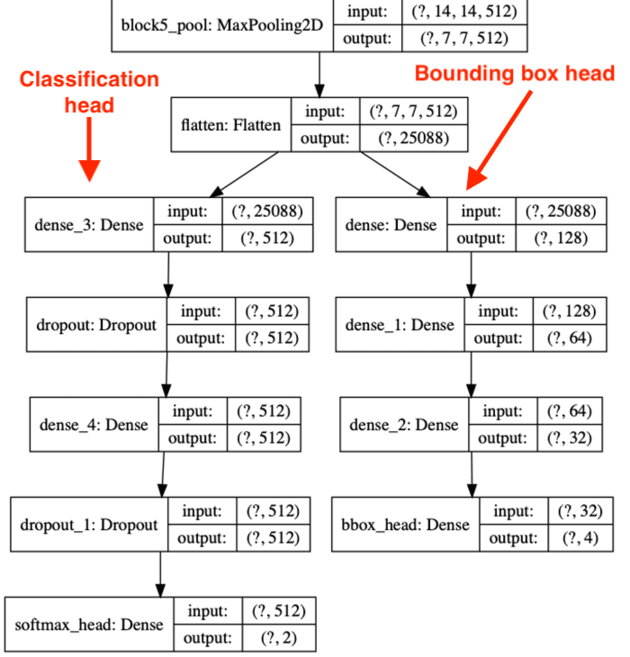

In [ ]:
# construct a fully-connected layer header to output the predicted
# bounding box coordinates
bboxHead = Dense(128, activation="relu")(flatten)
bboxHead = Dense(64, activation="relu")(bboxHead)
bboxHead = Dense(32, activation="relu")(bboxHead)
bboxHead = Dense(4, activation="sigmoid",
	name="bounding_box")(bboxHead)
# construct a second fully-connected layer head, this one to predict
# the class label
softmaxHead = Dense(512, activation="relu")(flatten)
softmaxHead = Dropout(0.5)(softmaxHead)
softmaxHead = Dense(512, activation="relu")(softmaxHead)
softmaxHead = Dropout(0.5)(softmaxHead)
softmaxHead = Dense(len(lb.classes_), activation="softmax",
	name="class_label")(softmaxHead)
# put together our model which accept an input image and then output
# bounding box coordinates and a class label
model = Model(
	inputs=vgg.input,
	outputs=(bboxHead, softmaxHead))


Figyeljük meg, hogy a réteg feje a VGG16 testéhez kapcsolódik, majd az osztálycímke-előrejelzéshez (balra) és a határoló doboz (x, y)-koordináta-előrejelzésekhez (jobbra) egy ágra válik szét.

A következő lépés a veszteségeink meghatározása és a modell összeállítása:
Definiáltunk egy szótárat a veszteségmódszereink tárolására. A kategorikus kereszt-entrópiát fogjuk használni az osztálycímke-águnkhoz és az átlagos négyzetes hibát a határoló doboz regressziós ághoz.

Ezután definiálunk egy lossWeights szótárat, amely megmondja a Keras/TensorFlow-nak, hogyan súlyozza az egyes ágakat a képzés során. Mindkét ágat egyformán akarjuk súlyozni, ezért a súlyértékeket mindegyiknél 1,0-ra állítjuk.

In [ ]:
# define a dictionary to set the loss methods -- categorical
# cross-entropy for the class label head and mean absolute error
# for the bounding box head
losses = {
	"class_label": "categorical_crossentropy",
	"bounding_box": "mean_squared_error",
}
# define a dictionary that specifies the weights per loss (both the
# class label and bounding box outputs will receive equal weight)
lossWeights = {
	"class_label": 1.0,   # a költségfüggvények súlyozása
	"bounding_box": 1.0
}
# initialize the optimizer, compile the model, and show the model
# summary
opt = Adam(learning_rate=INIT_LR)
model.compile(loss=losses, optimizer=opt, metrics=["accuracy"], loss_weights=lossWeights)
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 224, 224, 64)         1792      ['input_1[0][0]']             
                                                                                                  
 block1_conv2 (Conv2D)       (None, 224, 224, 64)         36928     ['block1_conv1[0][0]']        
                                                                                                  
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)         0         ['block1_conv2[0][0]']        
                                                                                              

Ezután még két szótárat kell definiálnunk:
A trainTargets szótár a képzési készletünk. Itt alkalmazzuk a trainLabels (az osztálycímke-előrejelzésekhez) és a trainBBoxes (a cél/alapigazság határoló dobozaink).

Hasonlóképpen, a testTargets szótárat a tesztkészletünkhöz is létrehozzuk.

Most már készen állunk a többosztályos határoló doboz regresszorunk képzésére:

In [ ]:
# construct a dictionary for our target training outputs
trainTargets = {
	"class_label": trainLabels,
	"bounding_box": trainBBoxes
}
# construct a second dictionary, this one for our target testing
# outputs
testTargets = {
	"class_label": testLabels,
	"bounding_box": testBBoxes
}

A .fit módszerrel képezzük ki a többosztályos határoló doboz regresszorunkat. Vegyük észre, hogy a trainImages és trainTargets képeket tesztelési adatként adjuk meg, míg a testImages és a testTargets képeket tesztelési adatként használjuk.

Miután a modellt betanítottuk, elmentjük a modellt a lemezre.

A LabelBinarizer objektumot azért mentjük, hogy a prediktáláskor a prediktált osztálycímkéket vissza tudjuk konvertálni ember által olvasható karakterláncokká.



In [ ]:
# train the network for bounding box regression and class label
# prediction
print("[INFO] training model...")
H = model.fit(
	trainImages, trainTargets,
	validation_data=(testImages, testTargets),
	batch_size=BATCH_SIZE,
	epochs=NUM_EPOCHS,
	verbose=1)
# serialize the model to disk
print("[INFO] saving object detector model...")
model.save(MODEL_PATH, save_format="h5")
# serialize the label binarizer to disk
print("[INFO] saving label binarizer...")
f = open(LB_PATH, "wb")
f.write(pickle.dumps(lb))
f.close()

[INFO] training model...
Epoch 1/20
5/5 [==============================] - 18s 848ms/step - loss: 1.2047 - bounding_box_loss: 0.0750 - class_label_loss: 1.1298 - bounding_box_accuracy: 0.4745 - class_label_accuracy: 0.4891 - val_loss: 0.6000 - val_bounding_box_loss: 0.0159 - val_class_label_loss: 0.5841 - val_bounding_box_accuracy: 0.6286 - val_class_label_accuracy: 0.8000
Epoch 2/20
5/5 [==============================] - 1s 194ms/step - loss: 0.6886 - bounding_box_loss: 0.0105 - class_label_loss: 0.6781 - bounding_box_accuracy: 0.5328 - class_label_accuracy: 0.6861 - val_loss: 0.2971 - val_bounding_box_loss: 0.0086 - val_class_label_loss: 0.2885 - val_bounding_box_accuracy: 0.6000 - val_class_label_accuracy: 0.9714
Epoch 3/20
5/5 [==============================] - 1s 195ms/step - loss: 0.3771 - bounding_box_loss: 0.0101 - class_label_loss: 0.3669 - bounding_box_accuracy: 0.5328 - class_label_accuracy: 0.9051 - val_loss: 0.2992 - val_bounding_box_loss: 0.0094 - val_class_label_loss: 0.

/usr/local/lib/python3.10/dist-packages/tf_keras/src/engine/training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


[INFO] saving label binarizer...


Készítsünk most egy ábrát a teljes veszteség, az osztálycímke-veszteség (kategorikus kereszt-entrópia) és a határoló doboz regressziós veszteség (átlagos négyzetes hiba) megjelenítéséhez.




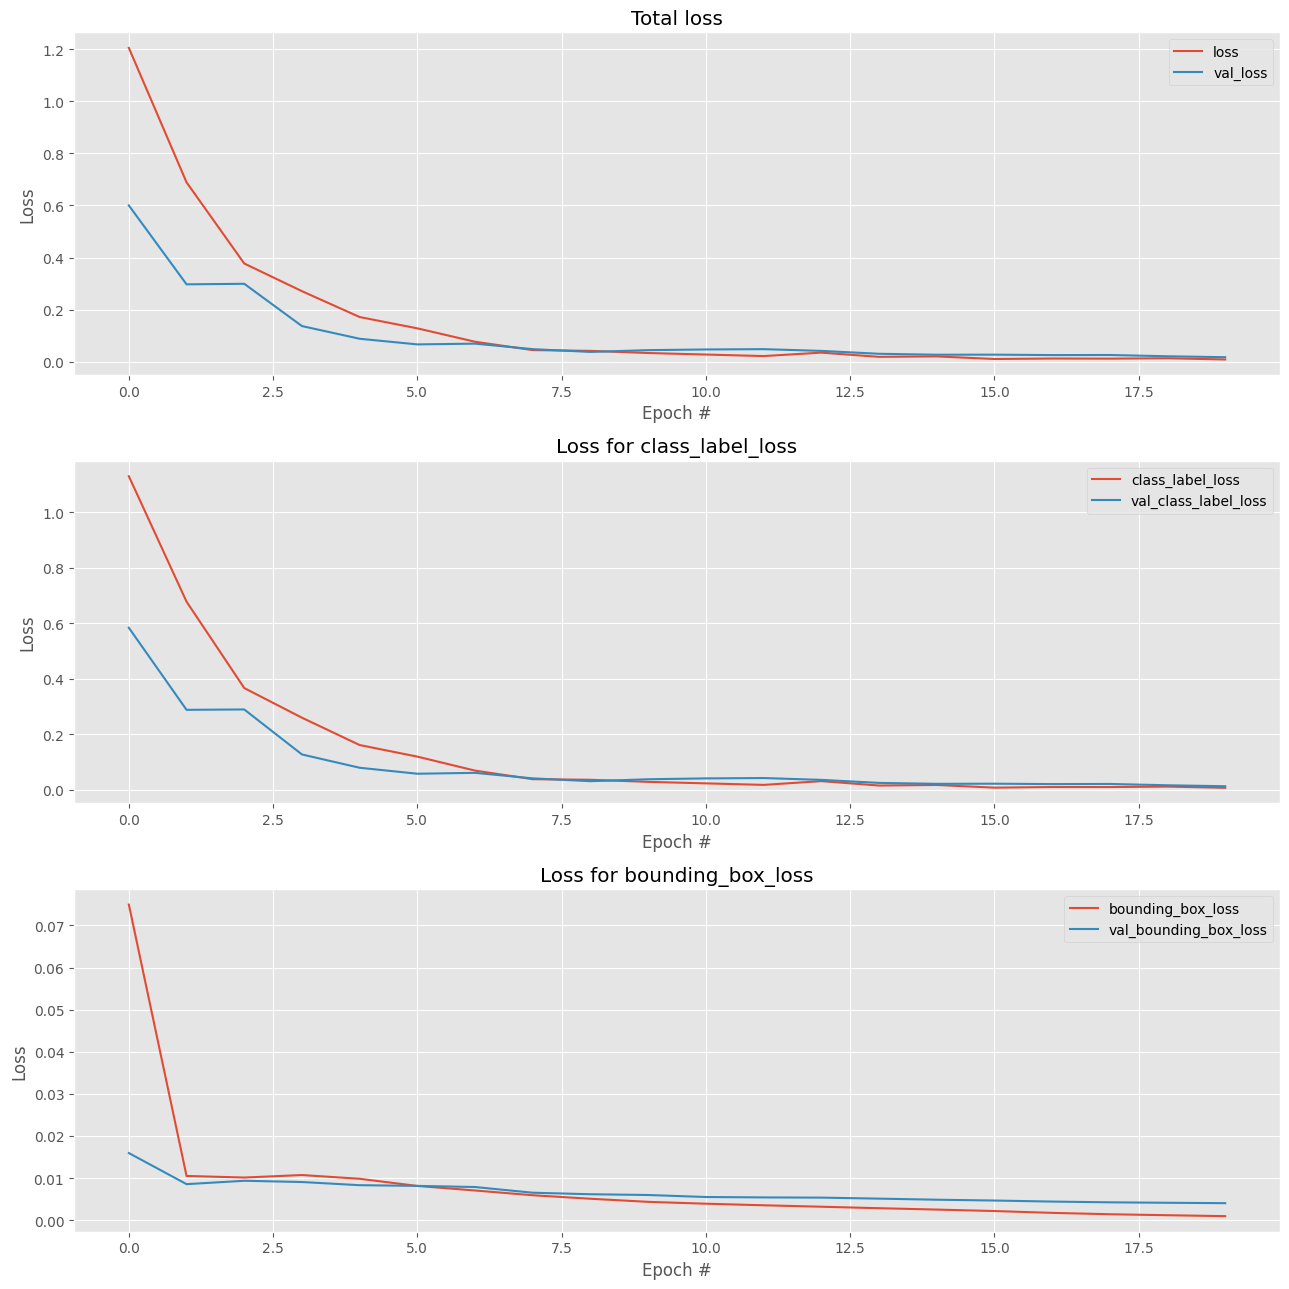

In [ ]:
# plot the total loss, label loss, and bounding box loss
lossNames = ["loss", "class_label_loss", "bounding_box_loss"]
N = np.arange(0, NUM_EPOCHS)
plt.style.use("ggplot")
(fig, ax) = plt.subplots(3, 1, figsize=(13, 13))

# loop over the loss names
for (i, l) in enumerate(lossNames):
    # plot the loss for both the training and validation data
    title = "Loss for {}".format(l) if l != "loss" else "Total loss"
    ax[i].set_title(title)
    ax[i].set_xlabel("Epoch #")
    ax[i].set_ylabel("Loss")
    ax[i].plot(N, H.history[l], label=l)
    ax[i].plot(N, H.history["val_" + l], label="val_" + l)
    ax[i].legend()
# save the losses figure and create a new figure for the accuracies
plt.tight_layout()
plotPath = os.path.sep.join([PLOTS_PATH, "losses.png"])
plt.savefig(plotPath)


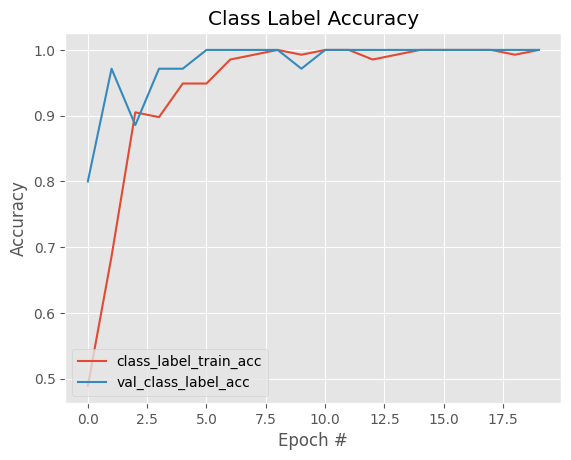

In [ ]:
# create a new figure for the accuracies
plt.style.use("ggplot")
plt.figure()
plt.plot(N, H.history["class_label_accuracy"],
	label="class_label_train_acc")
plt.plot(N, H.history["val_class_label_accuracy"],
	label="val_class_label_acc")
plt.title("Class Label Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend(loc="lower left")
# save the accuracies plot
plotPath = os.path.sep.join([PLOTS_PATH, "accs.png"])
plt.savefig(plotPath)

In [ ]:
imagePaths = open("Caltech/output/test_paths.txt").read().strip().split("\n")


In [ ]:
from tensorflow.keras.models import load_model

model2 = load_model(MODEL_PATH)
lb = pickle.loads(open(LB_PATH, "rb").read())

Végig iterálunk az összes képútvonalon. Majd minden egyes kép előfeldolgozása a következő módon történik:

betöltjük a bemeneti képet a lemezről, átméretezzük 224×224 pixelesre.
Átalakítjuk NumPy-táblává, és a képpontok intenzitását a [0, 1] tartományba skálázzuk.
Egy kötegelt dimenzió hozzáadása a képhez
Vegyük észre, hogy ezek pontosan ugyanazok az előfeldolgozási lépések, amelyeket korábban végeztünk el

Meghívjuk a modellünk .predict metódusát, amely két visszaadott értéket eredményez:

A határoló doboz előrejelzései (boxPreds).
És az osztálycímke-előrejelzések (labelPreds).
A 48. sorban kivonjuk a határoló doboz koordinátáit.

Az 52. sor meghatározza a legnagyobb megfelelő valószínűséggel rendelkező osztálycímkét, míg az 53. sor ezt az indexértéket használja az ember által olvasható osztálycímke-string kivonására a LabelBinarizerünkből.

Az utolsó lépés a határoló doboz koordinátáinak visszaméretezése a kép eredeti térbeli dimenzióira, majd a kimenetünk annotálása:

Betöltjük képet a lemezről, majd átméretezi azt 600px szélességűre (így garantálja, hogy a kép elfér a képernyőn).

A kép átméretezése után kiolvassuk a térbeli méreteit (azaz a szélességet és a magasságot).

Ne feledjük, hogy a határoló doboz regressziós modellünk a [0, 1] tartományban adja vissza a határoló doboz koordinátáit - de a képünk térbeli dimenziói a [0, w] és [0, h] tartományban vannak.

Ezért a kép térbeli dimenziói alapján átméretezzük a jósolt határoló dobozkoordinátákat.

Végül a kimeneti képet a megjósolt határoló doboz és a hozzá tartozó osztálycímke megrajzolásával megjeneítjük.


1/1 [==============================] - 1s 801ms/step


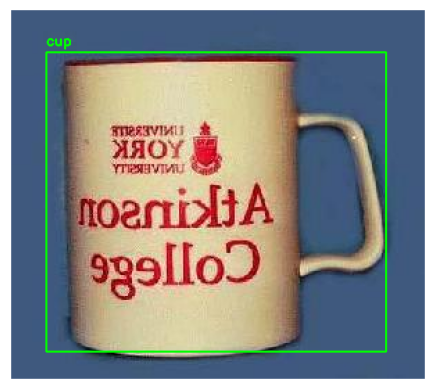

1/1 [==============================] - 0s 21ms/step


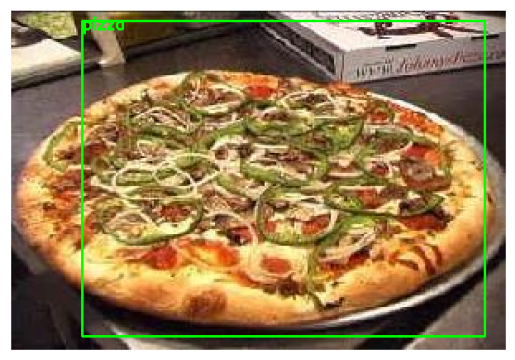

1/1 [==============================] - 0s 30ms/step


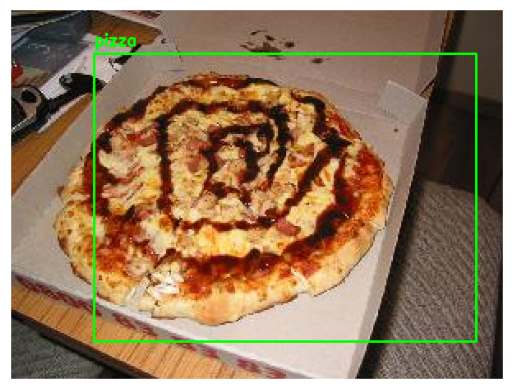

1/1 [==============================] - 0s 35ms/step


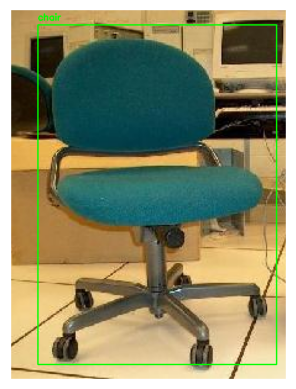

1/1 [==============================] - 0s 31ms/step


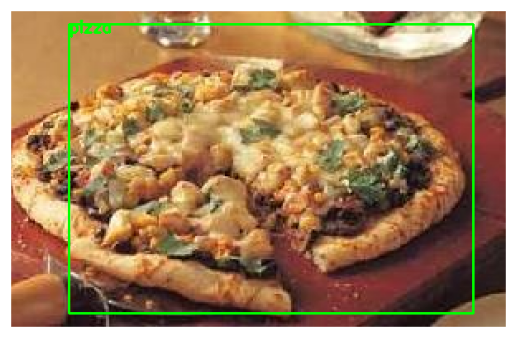

1/1 [==============================] - 0s 28ms/step


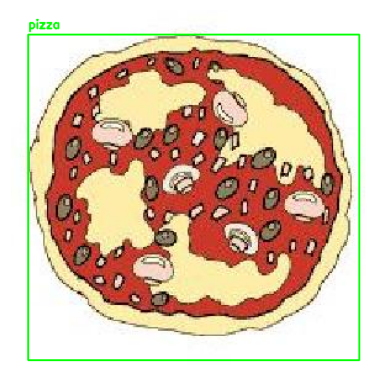

1/1 [==============================] - 0s 29ms/step


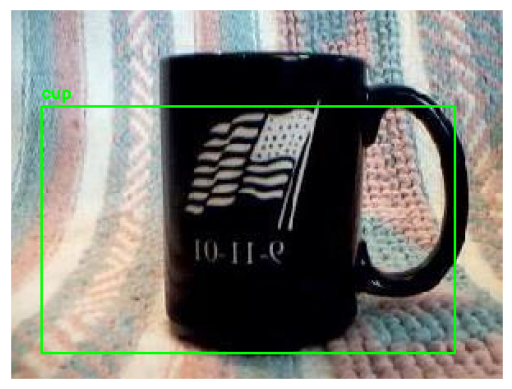

1/1 [==============================] - 0s 60ms/step


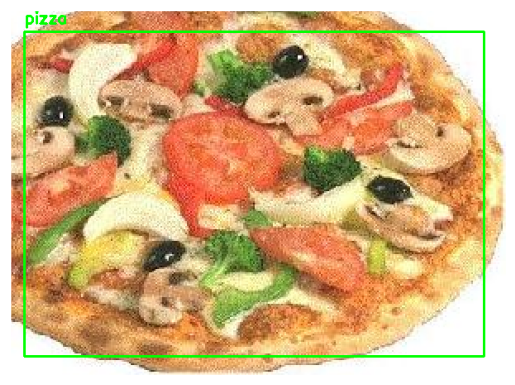

1/1 [==============================] - 0s 45ms/step


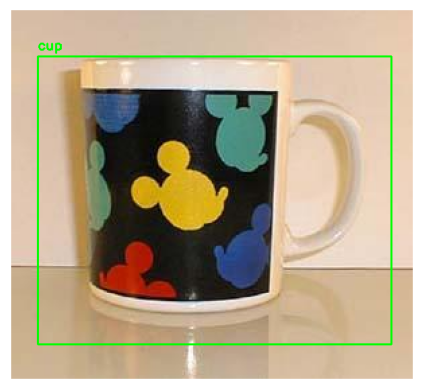

1/1 [==============================] - 0s 37ms/step


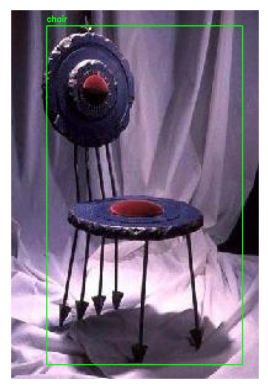

1/1 [==============================] - 0s 46ms/step


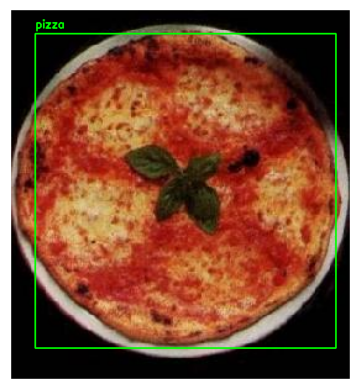

1/1 [==============================] - 0s 29ms/step


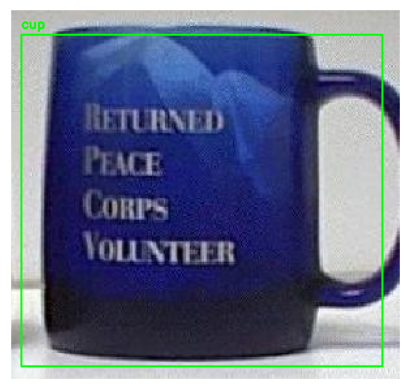

1/1 [==============================] - 0s 32ms/step


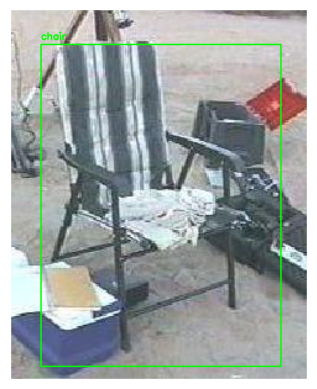

1/1 [==============================] - 0s 45ms/step


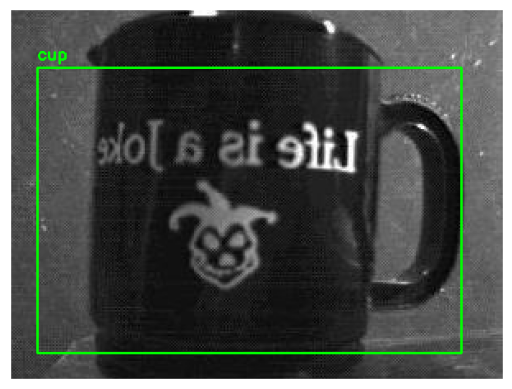

1/1 [==============================] - 0s 37ms/step


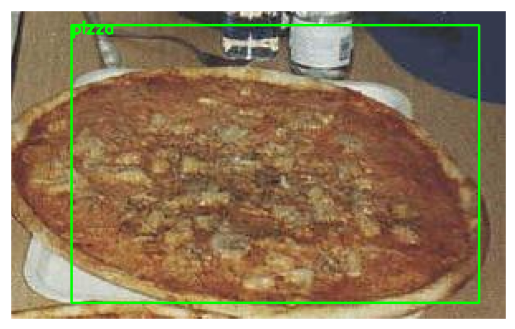

1/1 [==============================] - 0s 29ms/step


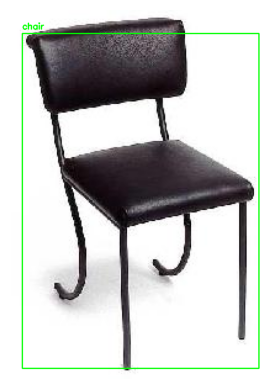

1/1 [==============================] - 0s 23ms/step


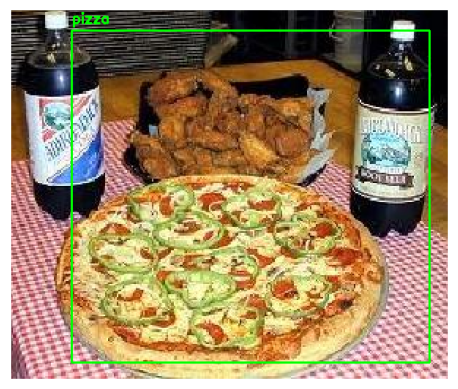

1/1 [==============================] - 0s 41ms/step


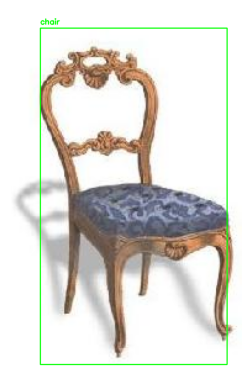

1/1 [==============================] - 0s 38ms/step


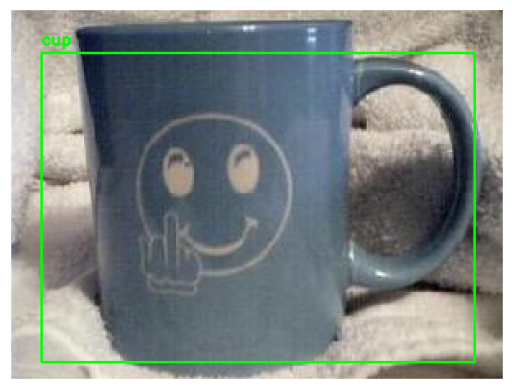

1/1 [==============================] - 0s 30ms/step


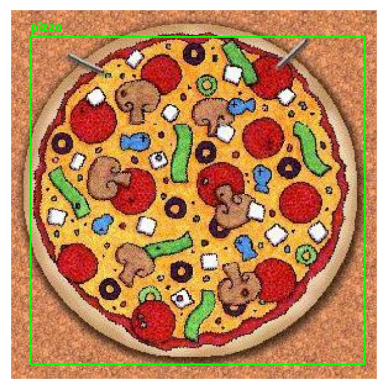

1/1 [==============================] - 0s 29ms/step


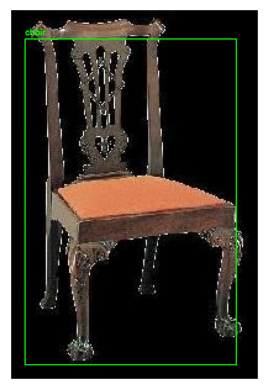

1/1 [==============================] - 0s 28ms/step


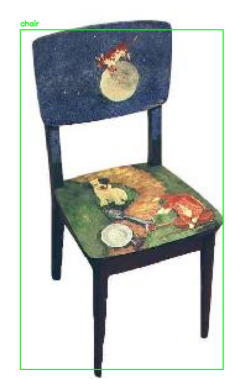

1/1 [==============================] - 0s 28ms/step


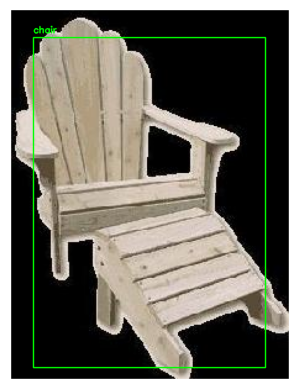

1/1 [==============================] - 0s 28ms/step


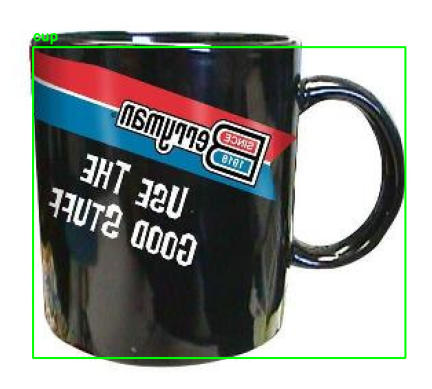

1/1 [==============================] - 0s 28ms/step


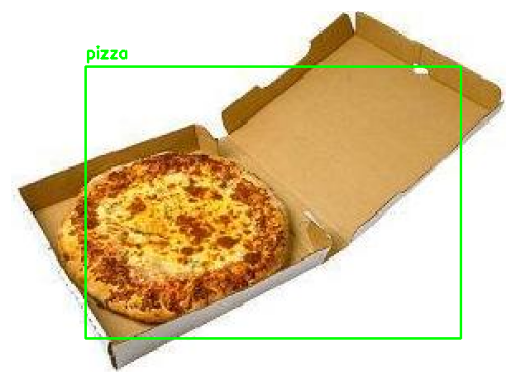

1/1 [==============================] - 0s 29ms/step


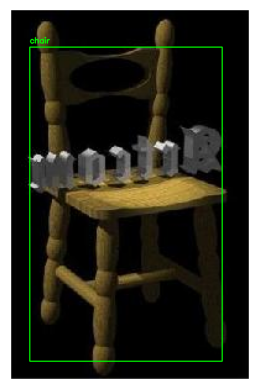

1/1 [==============================] - 0s 28ms/step


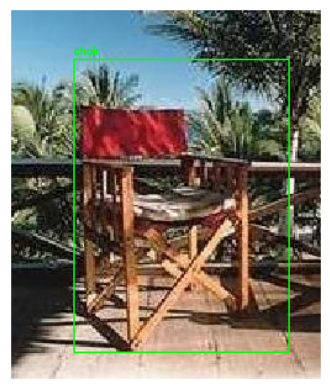

1/1 [==============================] - 0s 28ms/step


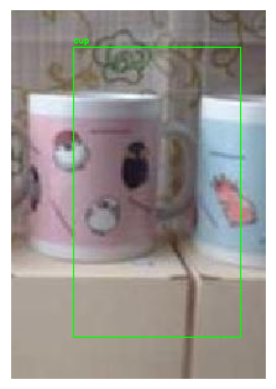

1/1 [==============================] - 0s 28ms/step


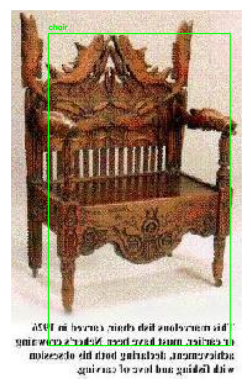

1/1 [==============================] - 0s 27ms/step


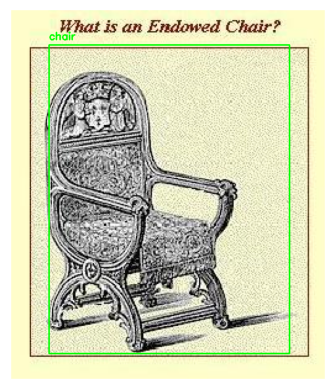

1/1 [==============================] - 0s 28ms/step


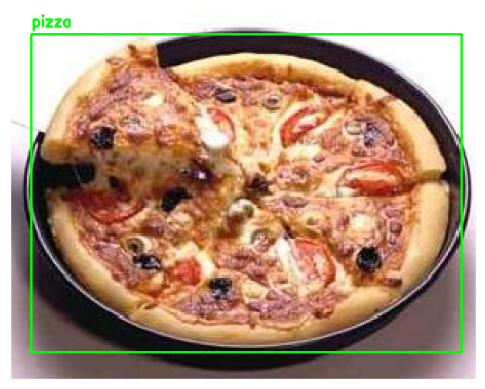

1/1 [==============================] - 0s 32ms/step


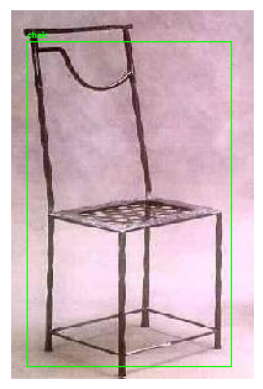

1/1 [==============================] - 0s 27ms/step


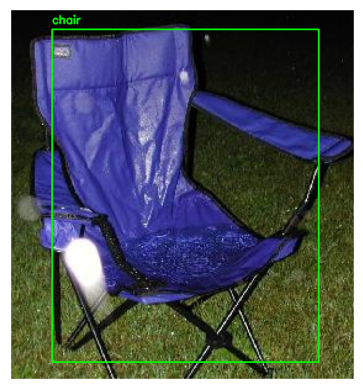

1/1 [==============================] - 0s 28ms/step


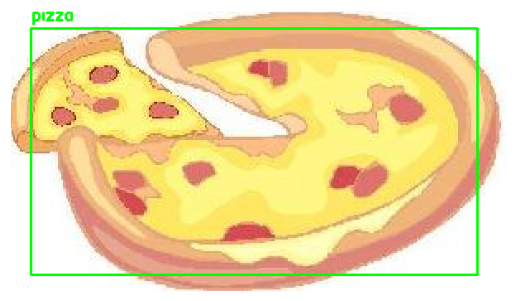

1/1 [==============================] - 0s 29ms/step


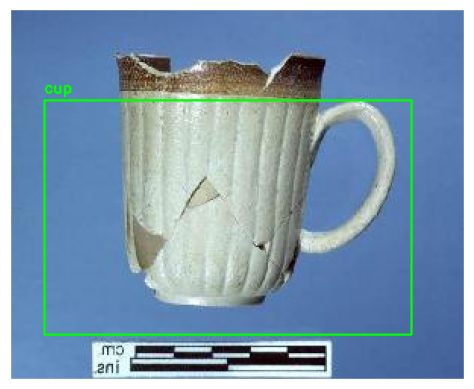

In [ ]:
import imutils

# loop over the images that we'll be testing using our bounding box
# regression model
for imagePath in imagePaths:
	  # load the input image (in Keras format) from disk and preprocess
	  # it, scaling the pixel intensities to the range [0, 1]
    image = load_img(imagePath, target_size=(224, 224))
    image = img_to_array(image) / 255.0
    image = np.expand_dims(image, axis=0)
	  # predict the bounding box of the object along with the class
	  # label
    (boxPreds, labelPreds) = model2.predict(image)
    (startX, startY, endX, endY) = boxPreds[0]
	  # determine the class label with the largest predicted
	  # probability
    i = np.argmax(labelPreds, axis=1)
    label = lb.classes_[i][0]
    image = cv2.imread(imagePath)
    image = imutils.resize(image, width=600)
    (h, w) = image.shape[:2]
    # scale the predicted bounding box coordinates based on the image
    # dimensions
    startX = int(startX * w)
    startY = int(startY * h)
    endX = int(endX * w)
    endY = int(endY * h)
    # draw the predicted bounding box and class label on the image
    y = startY - 10 if startY - 10 > 10 else startY + 10
    cv2.putText(image, label, (startX, y), cv2.FONT_HERSHEY_SIMPLEX, 0.65, (0, 255, 0), 2)
    cv2.rectangle(image, (startX, startY), (endX, endY), (0, 255, 0), 2)
	  # show the output image
    #cv2_imshow("Output", image)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.xticks([])
    plt.yticks([])
    plt.show()

In [ ]:
boxPreds

array([[0.07606025, 0.24640338, 0.8819355 , 0.8794476 ]], dtype=float32)